# AutoInland Vehicle Insurance Claim Challenge StarterNotebook - Python

This is a simple starter notebook to get started with the AutoInland Vehicle Insurance Claim Challenge on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

### Importing libraries

In [82]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

### Read files

In [23]:
# Load files into a pandas dataframe
train = pd.read_csv('./csv files/Train.csv')
test = pd.read_csv('./csv files/Test.csv')
ss = pd.read_csv('./csv files/SampleSubmission.csv')

## Eploratory Data Analysis

In [24]:
# Preview the first five rows of the train set
train.head()

,ID,Policy_Start_Date,Policy_End_Date,Gender,Age,First_Transaction_Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [25]:
# Preview the first five rows of the test set
test.head()

,ID,Policy_Start_Date,Policy_End_Date,Gender,Age,First_Transaction_Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


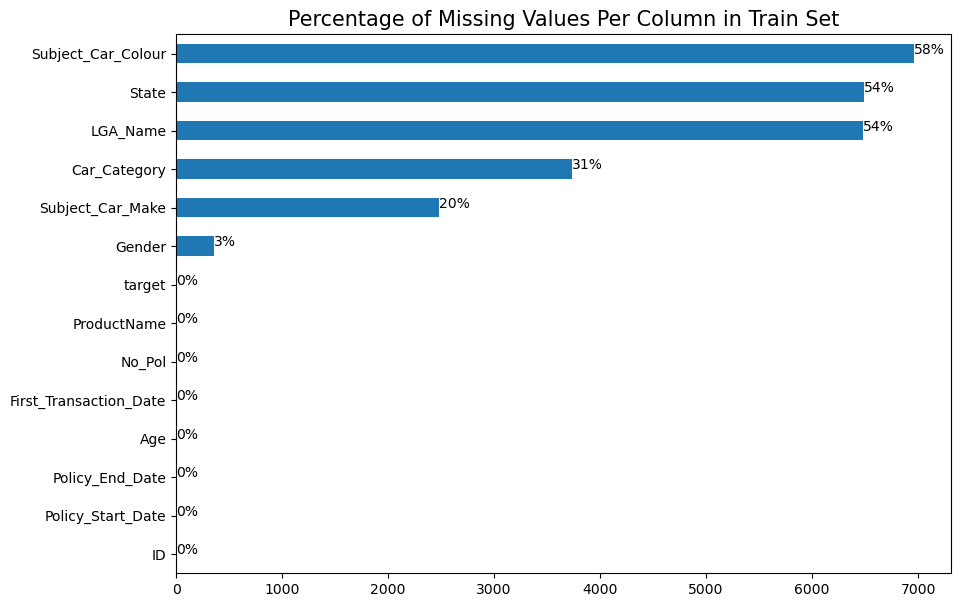

In [26]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Cleaning Data

### Adding other gender to "Other"

In [220]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
train.Gender = train.Gender.replace(mapper)

# Confirm mappings
train.Gender.value_counts()

Gender
Male      7617
Female    3327
Other      776
Name: count, dtype: int64

In [221]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
test.Gender = test.Gender.replace(mapper)

# Confirm mappings
test.Gender.value_counts()

Gender
Male      739
Female    352
Other      70
Name: count, dtype: int64

### Using mode based imputation on gender**

In [6]:
train['Gender'] = train['Gender'].fillna(train['Gender'].mode()[0])

In [7]:
test['Gender'] = test['Gender'].fillna(test['Gender'].mode()[0])

### Imputing age

In [28]:
def clean_age(age):
    if pd.isna(age) or age < 0 or age > 100:
        return np.nan
    return age

train['Age'] = train['Age'].apply(clean_age)
test['Age'] = test['Age'].apply(clean_age)


age_average = train['Age'].mean()
age_average_test = test['Age'].mean()

train['Age'].fillna(age_average, inplace=True)
test['Age'].fillna(age_average_test, inplace=True)

### Replace dots on subject car make

In [29]:
train['Subject_Car_Make'] = train['Subject_Car_Make'].replace('.', np.nan)

### Sorting the date

In [30]:
train = train.sort_values(by='Policy_Start_Date')

### Using Bacck_fill method

In [32]:
def backfill_data(data, columns):
    for column in columns:
        data[column] = data[column].fillna(method='bfill')
    return data

                   
backfill_columns = ['Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'Gender']
    
backfilled_data = backfill_data(train, backfill_columns)

print("Original Data:")
print(train)
print("\nBackfilled Data:")
print(backfilled_data)

backfilled_data.to_csv('./csv files/backfilled_data.csv', index=False)

Original Data:
               ID Policy_Start_Date Policy_End_Date  Gender   Age  \
8010   ID_O51ZQ1B        2001-12-11      2011-12-10  Female  37.0   
10526  ID_VJ1FAVO        2002-03-25      2011-03-24    Male  37.0   
10234  ID_ULWS8VL        2003-04-13      2011-04-12    Male  41.0   
12066  ID_ZYKGSP7        2003-12-21      2034-05-20    Male  48.0   
8124   ID_OEWBKGF        2005-08-05      2011-09-29  Female  44.0   
...           ...               ...             ...     ...   ...   
7479   ID_MLGO8DZ        2010-12-31      2011-06-30    Male  51.0   
1997   ID_62LBOWI        2010-12-31      2011-12-30    Male  44.0   
11299  ID_XR8F115        2010-12-31      2011-12-30    Male  37.0   
2919   ID_8P2UGYO        2010-12-31      2011-12-30    Male  20.0   
2886   ID_8MNXRC6        2010-12-31      2011-12-16    Male  36.0   

      First_Transaction_Date  No_Pol Car_Category Subject_Car_Colour  \
8010              2001-12-11       1       Saloon              Black   
10526       

In [33]:
test = test.sort_values(by='Policy_Start_Date')

In [34]:
def backfill_data(data, columns):
    for column in columns:
        data[column] = data[column].fillna(method='bfill')
    return data

                   
backfill_columns = ['Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State', 'Gender']
    
backfilled_data = backfill_data(test, backfill_columns)

print("Original Data:")
print(test)
print("\nBackfilled Data:")
print(backfilled_data)


Original Data:
              ID Policy_Start_Date Policy_End_Date  Gender        Age  \
195   ID_6JEYVLP        2010-01-01      2010-12-31    Male  35.000000   
379   ID_BX1PNZ6        2010-01-01      2011-05-31  Entity  93.000000   
248   ID_83NJU2D        2010-01-01      2010-12-31  Female  41.319241   
882   ID_Q6GKOAQ        2010-01-02      2011-01-01  Female  45.000000   
1092  ID_WB3E64W        2010-01-02      2011-01-01    Male  66.000000   
...          ...               ...             ...     ...        ...   
116   ID_3VAANJU        2010-12-30      2011-12-29  Female  41.000000   
307   ID_A1YSYCA        2010-12-30      2011-12-29    Male  45.000000   
1115  ID_X7F8710        2010-12-31      2011-12-30    Male  38.000000   
781   ID_MZPS3W5        2010-12-31      2011-07-10    Male  34.000000   
1047  ID_V1RSMQM        2010-12-31      2011-12-30     NaN  51.000000   

     First_Transaction_Date  No_Pol Car_Category Subject_Car_Colour  \
195              2010-01-01       1  

In [81]:
train.isnull().sum()

ID                        0
Policy_Start_Date         0
Policy_End_Date           0
Gender                    0
Age                       0
First_Transaction_Date    0
No_Pol                    0
Car_Category              0
Subject_Car_Colour        0
Subject_Car_Make          0
LGA_Name                  0
State                     0
ProductName               0
target                    0
dtype: int64

In [36]:
train

,ID,Policy_Start_Date,Policy_End_Date,Gender,Age,First_Transaction_Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
8010,ID_O51ZQ1B,2001-12-11,2011-12-10,Female,37.0,2001-12-11,1,Saloon,Black,Honda,Ekiti,Benue,Car Vintage,0
10526,ID_VJ1FAVO,2002-03-25,2011-03-24,Male,37.0,2002-03-25,1,Saloon,Black,TOYOTA,Ekiti,Benue,Car Classic,0
10234,ID_ULWS8VL,2003-04-13,2011-04-12,Male,41.0,2003-04-13,2,Saloon,Black,TOYOTA,Ikeja,Lagos,Car Vintage,0
12066,ID_ZYKGSP7,2003-12-21,2034-05-20,Male,48.0,2003-12-21,2,Saloon,Gold,BMW,Ajah,Lagos,Car Vintage,0
8124,ID_OEWBKGF,2005-08-05,2011-09-29,Female,44.0,2005-08-05,1,Saloon,Gold,Tata,Ajah,Lagos,CVTP,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7479,ID_MLGO8DZ,2010-12-31,2011-06-30,Male,51.0,2010-12-31,4,Saloon,Black,Honda,Victoria Island,Lagos,Car Classic,0
1997,ID_62LBOWI,2010-12-31,2011-12-30,Male,44.0,2010-12-31,1,JEEP,Silver,Hyundai,Victoria Island,Lagos,Car Classic,0
11299,ID_XR8F115,2010-12-31,2011-12-30,Male,37.0,2010-12-31,1,JEEP,Silver,Hyundai,Anthony Village,Lagos,CarSafe,0
2919,ID_8P2UGYO,2010-12-31,2011-12-30,Male,20.0,2010-12-31,1,Saloon,Silver,Kia,Anthony Village,Lagos,CarSafe,0


### Encode the columns using label encoder

In [37]:
categorical_cols = ["Gender", "Car_Category", "Subject_Car_Colour", "Subject_Car_Make", "ProductName", "Policy_Start_Date", "Policy_End_Date", "First_Transaction_Date", "LGA_Name", "State"]

le = LabelEncoder()
for col in categorical_cols:
    train[col] = le.fit_transform(train[col].astype(str))

In [38]:
categorical_cols = ["Gender", "Car_Category", "Subject_Car_Colour", "Subject_Car_Make", "ProductName", "Policy_Start_Date", "Policy_End_Date", "First_Transaction_Date", "LGA_Name", "State"]

le = LabelEncoder()
for col in categorical_cols:
    test[col] = le.fit_transform(test[col].astype(str))

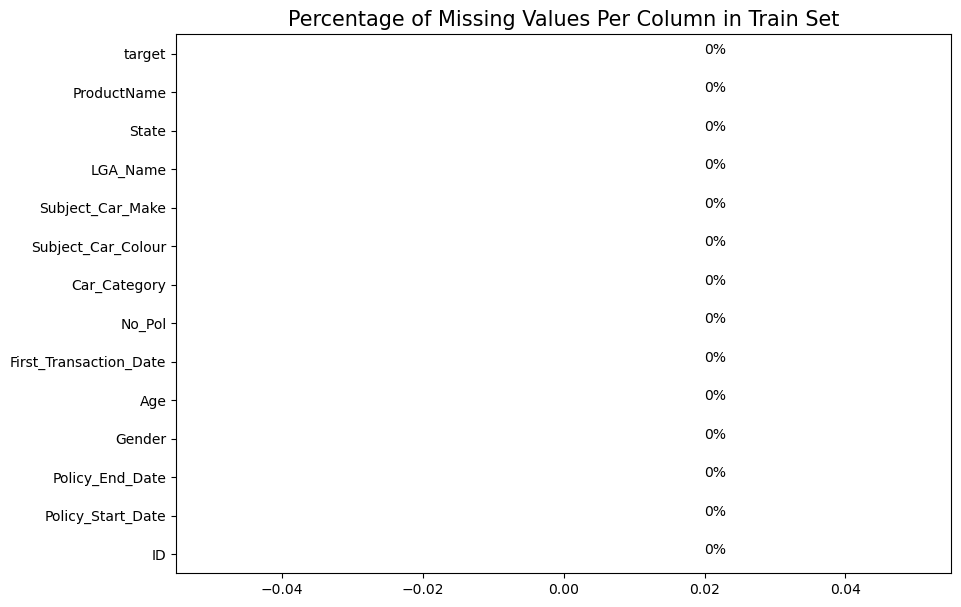

In [39]:
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Correlation Matrix

In [40]:

features = ['Policy_Start_Date', 'Policy_End_Date', 'Gender', 'Age',
       'First_Transaction_Date', 'No_Pol', 'Car_Category',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName', 'target']

corr_matrix = train[features].corr()
corr_matrix_df = corr_matrix.reset_index().melt(id_vars="index", var_name="Feature_2", value_name="Correlation")
corr_matrix_df.rename(columns={"index": "Feature_1"}, inplace=True)

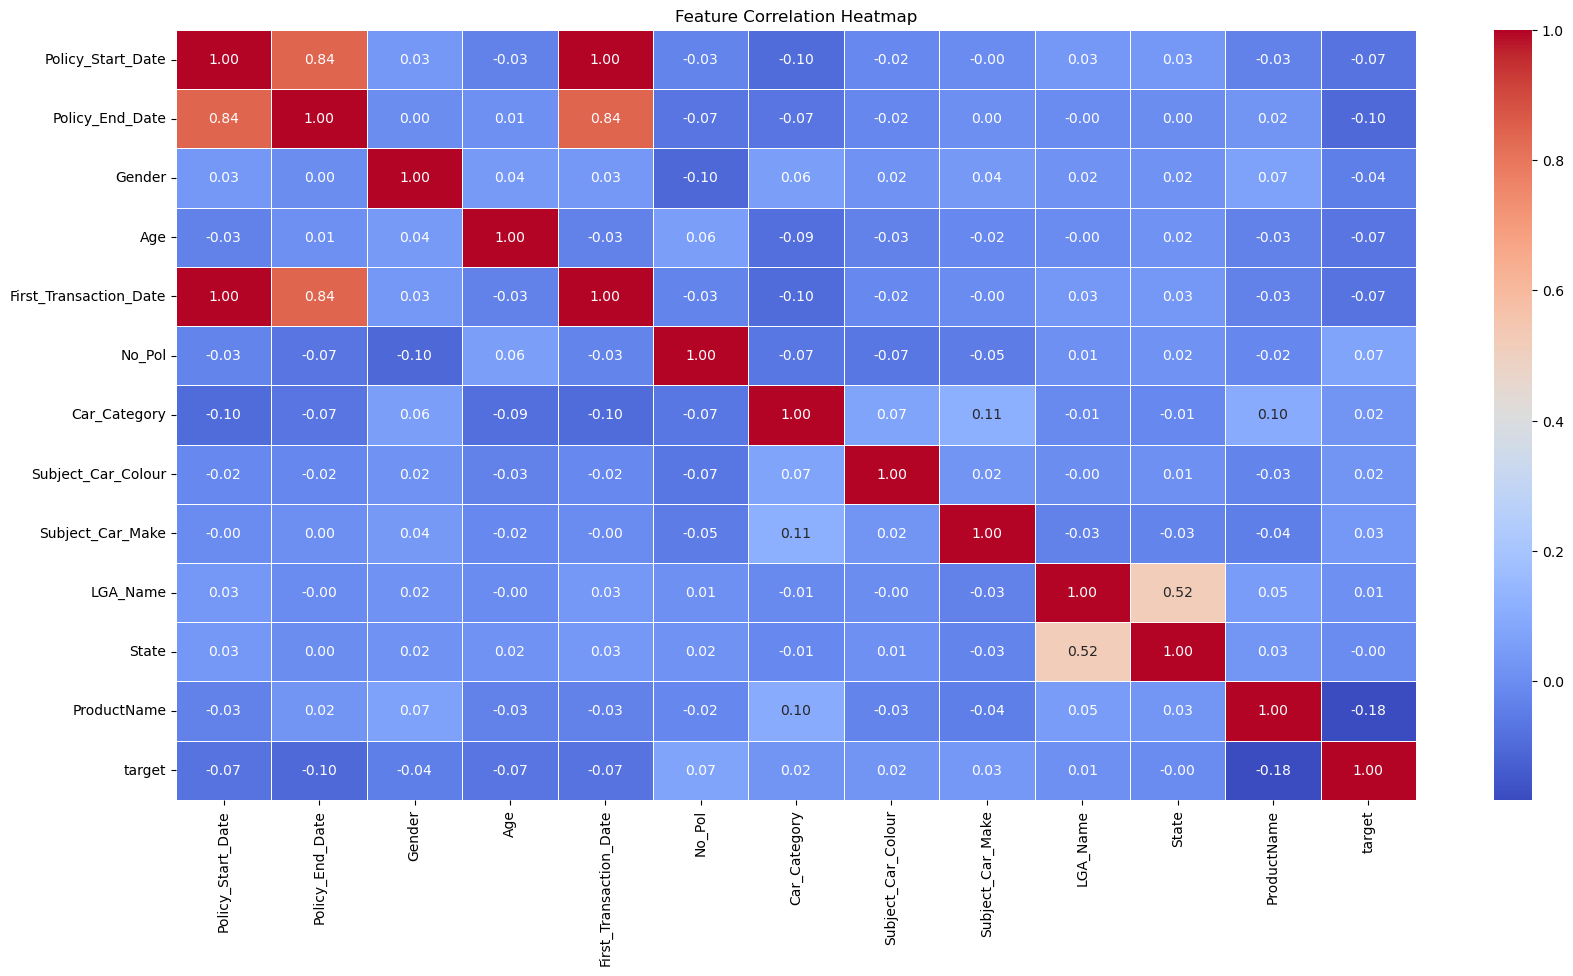

In [41]:
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [42]:
train.columns

Index(['ID', 'Policy_Start_Date', 'Policy_End_Date', 'Gender', 'Age',
       'First_Transaction_Date', 'No_Pol', 'Car_Category',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName', 'target'],
      dtype='object')

## Model Training

In [ ]:
X = train[["Policy_Start_Date", "Policy_End_Date", "Gender", "Age", "No_Pol", "Car_Category", "Subject_Car_Colour", "Subject_Car_Make", "ProductName", "LGA_Name", "State"]]
y = train[["target"]]

In [ ]:
X_test = test[["Policy_Start_Date", "Policy_End_Date", "Gender", "Age", "No_Pol", "Car_Category", "Subject_Car_Colour", "Subject_Car_Make", "ProductName", "LGA_Name", "State"]]


In [76]:
model = DecisionTreeClassifier()
model.fit(X, y) 
train_predictions = model.predict(X)

In [77]:
f1 = f1_score(y, train_predictions)
precision = precision_score(y, train_predictions)
recall = recall_score(y, train_predictions)
conf_matrix = confusion_matrix(y, train_predictions)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

F1 Score: 0.8154
Precision: 0.9679
Recall: 0.7045
Confusion Matrix:
[[10590    34]
 [  430  1025]]


In [78]:
test_predictions = model.predict(X_test)
print(test_predictions)

[0 0 0 ... 0 0 0]


In [79]:
test_predictions = model.predict(X_test)
pd.set_option('display.max_rows', 20)

pd.DataFrame(test_predictions).value_counts()

0
0    963
1    239
Name: count, dtype: int64

In [80]:
ss['target'] = test_predictions
ss.to_csv('submission.csv', index=False)

# ******************* GOOD LUCK!!! ***************************